# Measuring centroids and position angles for the LoVoCCS sample

## Import Statements

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
from astropy.units import Quantity, UnitConversionError
from astropy.cosmology import LambdaCDM
from shutil import rmtree
import os
from matplotlib import pyplot as plt

import xga
xga.NUM_CORES = 5
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample

# This is a bit cheeky, but suppresses the warnings that XGA spits out (they are 
#  useful, but not when I'm trying to present this notebook on GitHub)
import warnings
warnings.filterwarnings('ignore')

# Set up a variable that controls how long individual XSPEC fits are allowed to run
timeout = Quantity(6, 'hr')

%matplotlib inline

## Setting up necessary directories

Here we ensure that the directories we need to store the outputs in have been created:

In [2]:
if not os.path.exists("../../outputs/figures/positions/"):
    os.makedirs("../../outputs/figures/positions/")
    
if not os.path.exists("../../outputs/coordinates"):
    os.makedirs("../../outputs/coordinates/")
    
if not os.path.exists("../../outputs/cluster_visualisations/centroid_posangle_meas/"):
    os.makedirs("../../outputs/cluster_visualisations/centroid_posangle_meas/")

## Defining any useful functions

In [16]:
def centroid_shape_estimate(rel_src, ap_rad, cent_coord=None):
    
    cur_rt = src.get_combined_ratemaps()
    cont_mask = src.get_interloper_mask()
    
    if ap_rad is not None:
        ap_mask = src.get_custom_mask(ap_rad, remove_interlopers=False, central_coord=cent_coord)
    else:
        ap_mask = np.ones(cur_rt.shape)
        
    tot_mask = ap_mask*cont_mask
    
    data_cp = cur_rt.data.copy()
    msk_data = data_cp*tot_mask
    norm_data = msk_data / msk_data.sum()
    
    arr_x, arr_y = np.meshgrid(np.arange(0, norm_data.shape[1], ), np.arange(0, norm_data.shape[0]))
    
    x_cen_pix = (norm_data*arr_x).sum()
    y_cen_pix = (norm_data*arr_y).sum()
    cen_pix = [x_cen_pix, y_cen_pix]
    cen_pix_quan = Quantity([x_cen_pix, y_cen_pix], 'pix')
    

#     cen_deg = cur_rt.coord_conv(cen_pix, 'deg')
    covar = np.zeros((2, 2))
    covar[0, 0] = (norm_data*np.square(arr_x - cen_pix[0])).sum()
    covar[1, 1] = (norm_data*np.square(arr_y - cen_pix[1])).sum()
    covar[0, 1] = (norm_data * (arr_x - cen_pix[0]) * (arr_y - cen_pix[1])).sum()
    covar[1, 0] = covar[0, 1]
    
#     np.arctan2(rec_x, rec_y) - start_ang
    
    # TODO Try to normalise this output + ensure that it is North of East (does my head in)
    theta = 0.5*np.arctan((2*covar[1, 0]) / (covar[0, 0]-covar[1, 1]))*(180/np.pi)
    
    eig_pl = ((covar[0, 0] + covar[1, 1]) + np.sqrt((covar[0, 0] - covar[0, 0])**2 + 4*covar[0, 1]**2)) / 2
    eig_mi = ((covar[0, 0] + covar[1, 1]) - np.sqrt((covar[0, 0] - covar[0, 0])**2 + 4*covar[0, 1]**2)) / 2

    x_s = np.sqrt(eig_pl)
    y_s = np.sqrt(eig_mi)
    
    return cur_rt.coord_conv(cen_pix_quan, 'deg'), theta, x_s, y_s
    

## Reading in the sample

We read in the LoVoCCS sample relevant to the current work:

In [4]:
samp = pd.read_csv("../../sample_files/X-LoVoCCSI.csv")
samp['LoVoCCS_name'] = samp['LoVoCCSID'].apply(lambda x: "LoVoCCS-" + str(x))
samp

,LoVoCCSID,Name,start_ra,start_dec,MCXC_Redshift,MCXC_R500,MCXC_RA,MCXC_DEC,manual_xray_ra,manual_xray_dec,LoVoCCS_name
0,1,A2029,227.734300,5.745471,0.0766,1.3344,227.73000,5.720000,227.734300,5.745471,LoVoCCS-1
1,2,A401,44.740000,13.580000,0.0739,1.2421,44.74000,13.580000,NaN,NaN,LoVoCCS-2
2,4,A85,10.458750,-9.301944,0.0555,1.2103,10.45875,-9.301944,NaN,NaN,LoVoCCS-4
3,5,A3667,303.157313,-56.845978,0.0556,1.1990,303.13000,-56.830000,303.157313,-56.845978,LoVoCCS-5
4,7,A3827,330.480000,-59.950000,0.0980,1.1367,330.48000,-59.950000,NaN,NaN,LoVoCCS-7
...,...,...,...,...,...,...,...,...,...,...,...
61,121,A3128,52.466189,-52.580728,0.0624,0.8831,52.50000,-52.600000,52.466189,-52.580728,LoVoCCS-121
62,122,A1023,157.000000,-6.800000,0.1176,0.8553,157.00000,-6.800000,NaN,NaN,LoVoCCS-122
63,123,A3528,193.670000,-29.220000,0.0544,0.8855,193.67000,-29.220000,NaN,NaN,LoVoCCS-123
64,131,A761,137.651250,-10.581111,0.0916,0.8627,137.65125,-10.581111,NaN,NaN,LoVoCCS-131


In [5]:
# TODO OBVIOUSLY REMOVE THIS
samp = samp.sample(5, random_state=907)
samp

,LoVoCCSID,Name,start_ra,start_dec,MCXC_Redshift,MCXC_R500,MCXC_RA,MCXC_DEC,manual_xray_ra,manual_xray_dec,LoVoCCS_name
35,49,A1348,175.350000,-12.270000,0.1195,0.9548,175.350000,-12.270000,NaN,NaN,LoVoCCS-49
2,4,A85,10.458750,-9.301944,0.0555,1.2103,10.458750,-9.301944,NaN,NaN,LoVoCCS-4
30,46A,A2440Centre,335.987686,-1.583249,0.0906,0.9716,335.970000,-1.640000,335.987686,-1.583249,LoVoCCS-46A
9,13,A3112,49.490000,-44.240000,0.0752,1.1288,49.490000,-44.240000,NaN,NaN,LoVoCCS-13
28,42,A3822,328.538333,-57.855278,0.0760,0.9991,328.538333,-57.855278,NaN,NaN,LoVoCCS-42


## Defining an XGA ClusterSample

In [6]:
srcs = ClusterSample(samp['start_ra'].values, samp['start_dec'].values, samp['MCXC_Redshift'].values, 
                     samp['LoVoCCS_name'].values, r500=Quantity(samp['MCXC_R500'].values, 'Mpc'), use_peak=False, 
                     clean_obs=False)
srcs.info()

Setting up Galaxy Clusters: 100%|██████████| 5/5 [00:47<00:00,  9.43s/it]


-----------------------------------------------------
Number of Sources - 5
Redshift Information - True
Sources with ≥1 detection - 5 [100%]
-----------------------------------------------------



## 

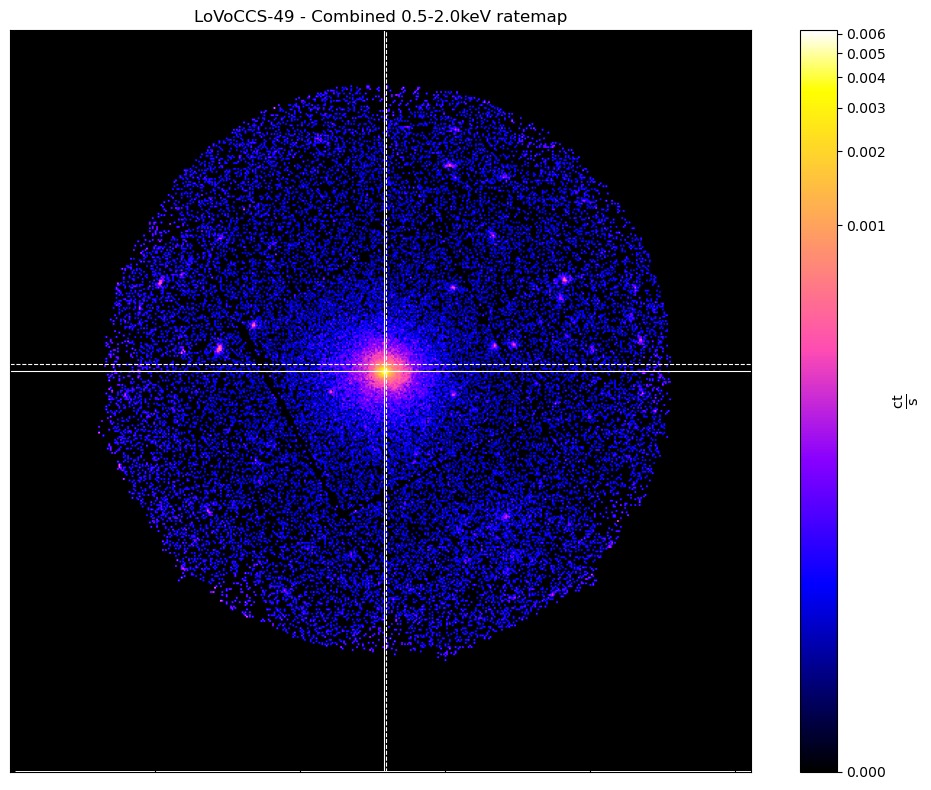

LoVoCCS-49 [175.35124372 -12.2765433 ] deg -15.85559631126181 16.476710774136524 15.946496887917819



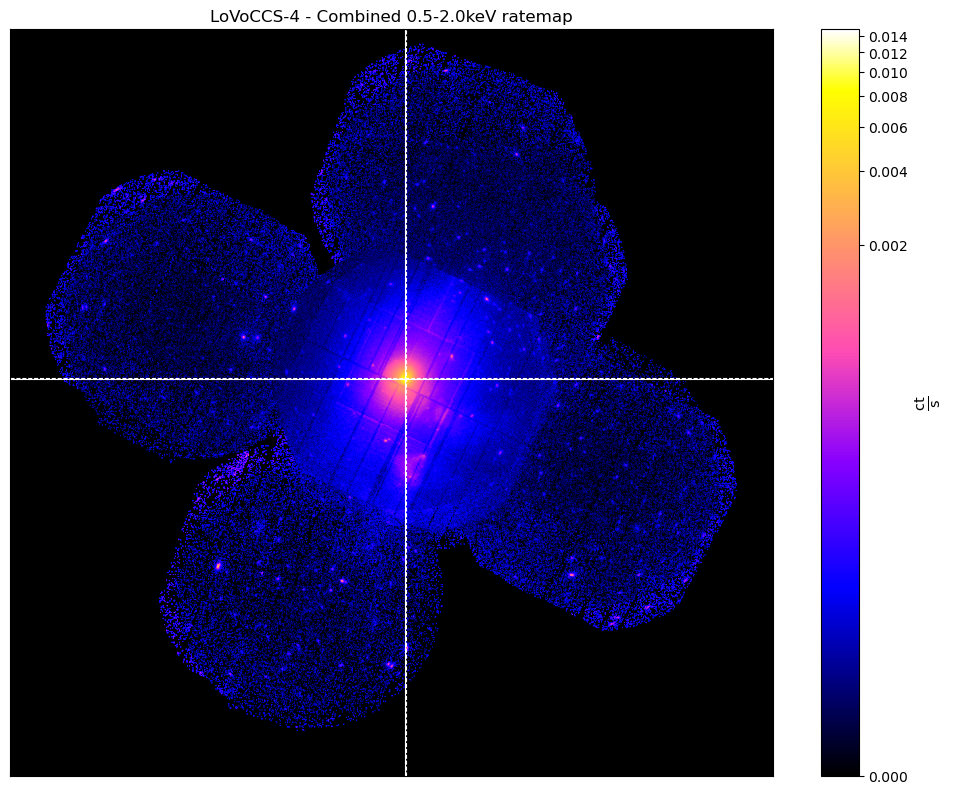

LoVoCCS-4 [10.46029705 -9.30428986] deg -23.224205146592407 36.8145478695699 33.50673318546907



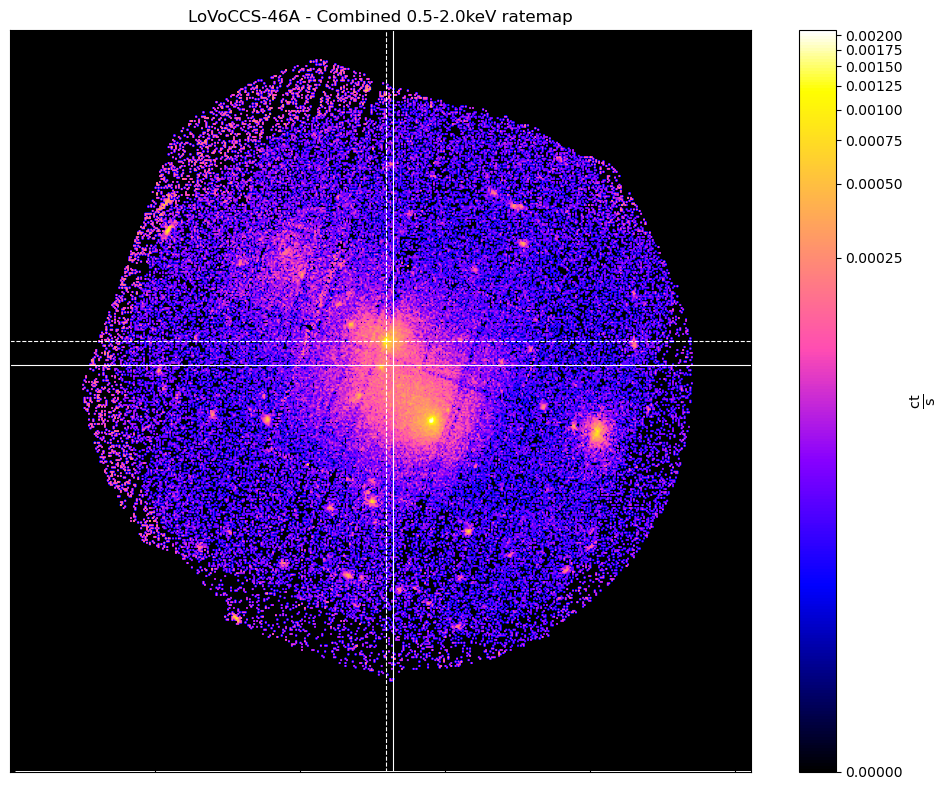

LoVoCCS-46A [335.98127807  -1.60356995] deg 32.25331154080274 32.70036874569528 25.424638206339626



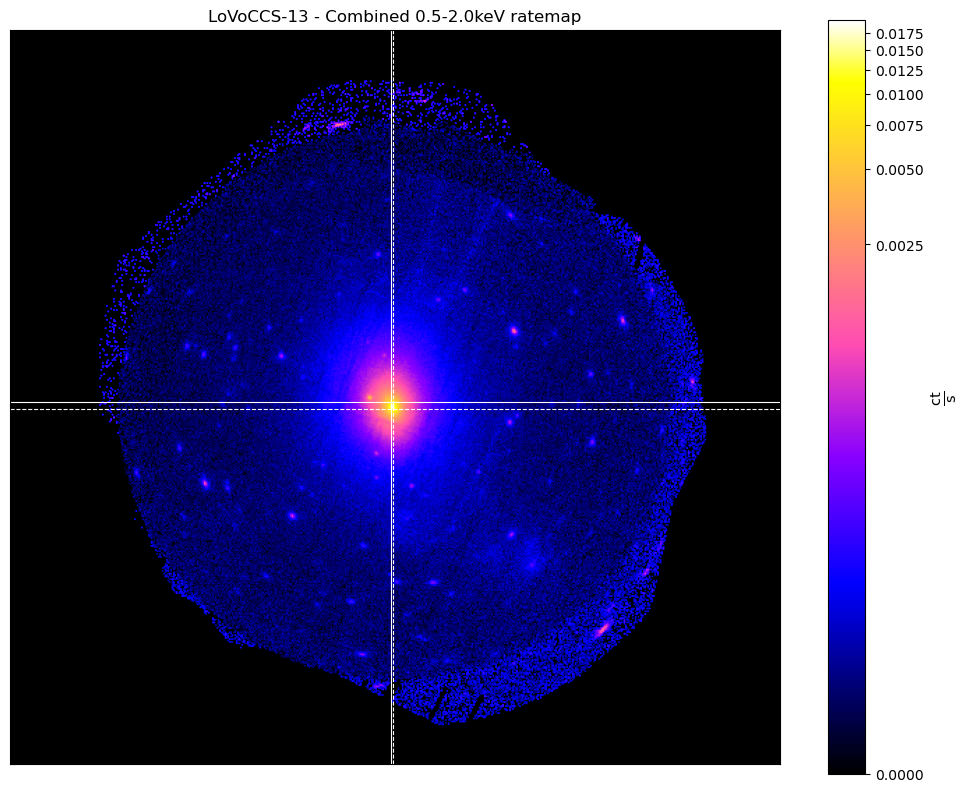

LoVoCCS-13 [ 49.49197192 -44.2346392 ] deg 9.191570971193034 22.680249497384708 21.941279805645305



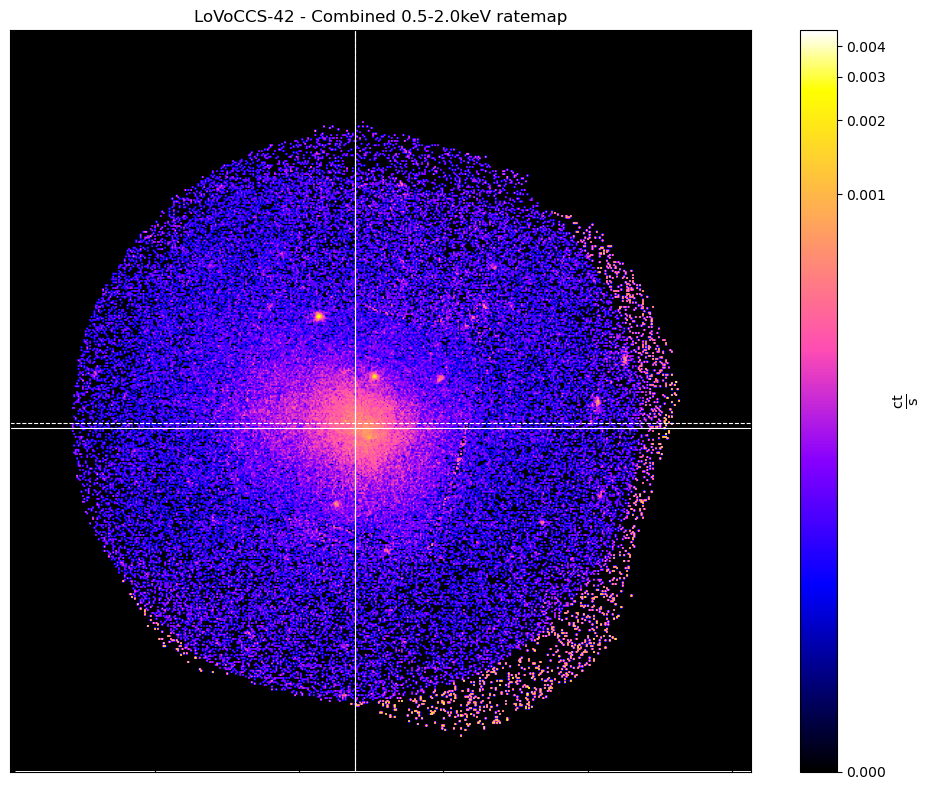

LoVoCCS-42 [328.53730287 -57.85817305] deg -25.510468698958736 33.56645939449078 31.230631235866625



In [17]:
for src in srcs:
    cur_cen, cur_ang, cur_x_scale, cur_y_scale = centroid_shape_estimate(src, Quantity(500, 'kpc'))
    src.get_combined_ratemaps().view(Quantity([cur_cen, src.ra_dec]))
    print(src.name, cur_cen, cur_ang, cur_x_scale, cur_y_scale)
    print('')